In this notebook, I try to perform EDA, numeric analysis, feature engineering and modeling by using sklearn.

In [1]:
import numpy
import pandas
import random

from sklearn.model_selection import train_test_split, cross_validate, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.exceptions import ConvergenceWarning

from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, SVMSMOTE
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks

import matplotlib.pyplot as plt
import seaborn as sns

from utils import util

import warnings
warnings.simplefilter(action='ignore')
warnings.simplefilter('ignore', ConvergenceWarning)

In [2]:
data = pandas.read_csv(util.dataset_filename)
data

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


Drop customerID and specify the target column

In [4]:
data.drop(['customerID'], axis=1, inplace=True)
target_column = 'Churn'

TotalCharges data type is object, which means there's something other than numbers in it. Let's replace 'em all with mean:

In [5]:
mask = pandas.to_numeric(data['TotalCharges'], errors='coerce').isna()
mean_val = numpy.mean(data.loc[~mask, 'TotalCharges'].astype(float))
data.loc[mask, 'TotalCharges'] = mean_val
data['TotalCharges'] = pandas.to_numeric(data['TotalCharges'], errors='coerce')
data['TotalCharges']

0         29.85
1       1889.50
2        108.15
3       1840.75
4        151.65
         ...   
7038    1990.50
7039    7362.90
7040     346.45
7041     306.60
7042    6844.50
Name: TotalCharges, Length: 7043, dtype: float64

From the data, it seems TotalCharges, MonthlyCharges, and tenure are numerical features. Let's review them.

In [6]:
numerical_columns = ['TotalCharges', 'MonthlyCharges', 'tenure']
data[numerical_columns].describe().T

,count,mean,std,min,25%,50%,75%,max
TotalCharges,7043.0,2283.300441,2265.000258,18.80,402.225,1400.55,3786.60,8684.80
MonthlyCharges,7043.0,64.761692,30.090047,18.25,35.500,70.35,89.85,118.75
tenure,7043.0,32.371149,24.559481,0.00,9.000,29.00,55.00,72.00


We are ready to use box-and-whisker plots for getting some insights regarding the numerical data:

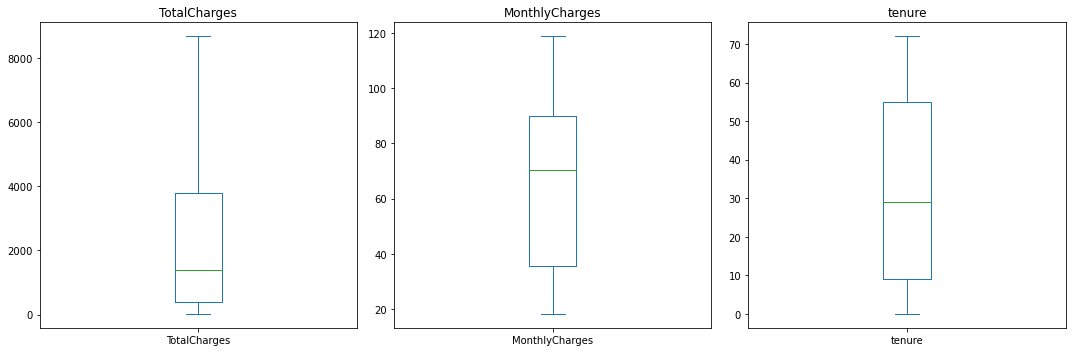

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=len(numerical_columns), figsize=(15, 5))

for i, column in enumerate(numerical_columns):
    data[column].plot(kind='box', ax=axes[i])
    axes[i].set_title(column)
plt.tight_layout()
plt.show()

- TotalCharges: it indicates TotalCharges has a wide range of values with a high variability in the data.

- MonthlyCharges: it indicates MonthlyCharges also has a wide range of values but with less variability than TotalCharges.

- tenure: it indicates the range of values for tenure is relatively narrow with moderate variability in the data.

Add the rest of columns as categorical/discrete data(except the 'Churn') to a list:

In [8]:
# We could also use select_dtype for finding categorical columns, but it does not recoginze 'SeniorCitizen'
# and we can't add int64 to the list since 'tenure' is also int64 but a numerical feature(overhead).
# categorized_columns = data.select_dtypes(include=['object', 'category']).columns.tolist()
categorized_columns = ['PaymentMethod', 'PaperlessBilling', 'Contract', 'StreamingMovies', 'StreamingTV', 
        'TechSupport', 'DeviceProtection', 'OnlineBackup', 'OnlineSecurity', 'InternetService', 'MultipleLines',
        'PhoneService', 'Dependents', 'Partner', 'SeniorCitizen', 'gender']

Understanding categories:

In [9]:
for column in categorized_columns:
    print(column, len(data[column].unique()))
    print(data[column].value_counts())
    print('-'*10)

PaymentMethod 4
Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: PaymentMethod, dtype: int64
----------
PaperlessBilling 2
Yes    4171
No     2872
Name: PaperlessBilling, dtype: int64
----------
Contract 3
Month-to-month    3875
Two year          1695
One year          1473
Name: Contract, dtype: int64
----------
StreamingMovies 3
No                     2785
Yes                    2732
No internet service    1526
Name: StreamingMovies, dtype: int64
----------
StreamingTV 3
No                     2810
Yes                    2707
No internet service    1526
Name: StreamingTV, dtype: int64
----------
TechSupport 3
No                     3473
Yes                    2044
No internet service    1526
Name: TechSupport, dtype: int64
----------
DeviceProtection 3
No                     3095
Yes                    2422
No internet service    1526
Name: DeviceProtection, dtype: int64
----------
OnlineBack

Now, let us visualize them by looping through each categorical feature and plot the categories(double-click on the figure to see with a fine quality):

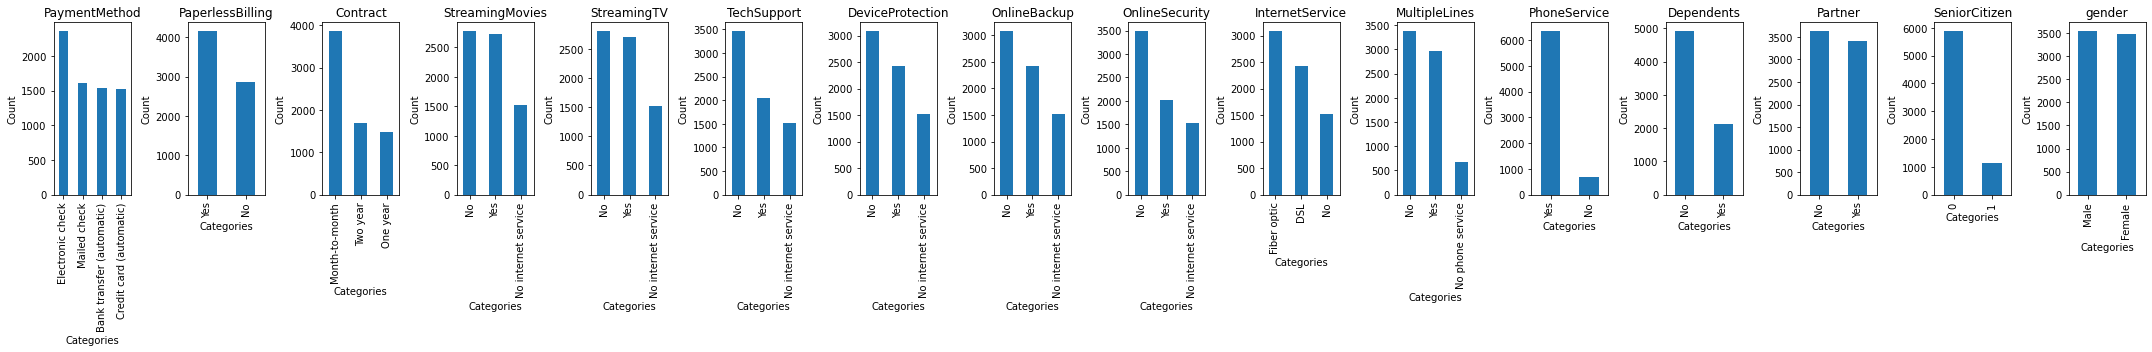

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=len(categorized_columns), figsize=(30, 5))
for i, column in enumerate(categorized_columns):
    data[column].value_counts().plot(kind='bar', ax=axes[i])
    axes[i].set_title(column)
    axes[i].set_xlabel('Categories')
    axes[i].set_ylabel('Count')
    
plt.tight_layout()
plt.show()

Convert categorical and discrete data to dummy variables. In this way, every class has its own column/feature:

In [11]:
data[target_column] = data[target_column].replace(['Yes', 'No'], [1.0, 0.0])
data_dummies = pandas.get_dummies(data)
data_dummies.head(5)

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,29.85,29.85,0.0,1,0,0,1,1,...,0,1,0,0,0,1,0,0,1,0
1,0,34,56.95,1889.50,0.0,0,1,1,0,1,...,0,0,1,0,1,0,0,0,0,1
2,0,2,53.85,108.15,1.0,0,1,1,0,1,...,0,1,0,0,0,1,0,0,0,1
3,0,45,42.30,1840.75,0.0,0,1,1,0,1,...,0,0,1,0,1,0,1,0,0,0
4,0,2,70.70,151.65,1.0,1,0,1,0,1,...,0,1,0,0,0,1,0,0,1,0


We can also change data variable by labeling categorical data:

In [12]:
data_labeled = data.copy()
for column in categorized_columns:
    get_classes = data[column].unique()
    data_labeled[column] = data[column].replace(get_classes, list(range(len(get_classes))))
data_labeled.head(5)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,29.85,29.85,0.0
1,1,0,1,0,34,1,1,0,1,1,1,0,0,0,1,1,1,56.95,1889.50,0.0
2,1,0,1,0,2,1,1,0,1,0,0,0,0,0,0,0,1,53.85,108.15,1.0
3,1,0,1,0,45,0,0,0,1,1,1,1,0,0,1,1,2,42.30,1840.75,0.0
4,0,0,1,0,2,1,1,1,0,1,0,0,0,0,0,0,0,70.70,151.65,1.0


Integrate and rescale data by using minmax rescaling(it doesn't touch target_column):

In [13]:
data_dummies = util.minmax_rescaling(data_dummies.columns, data_dummies)
data_dummies.head(5)

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0.0,0.013889,0.115423,0.001275,0.0,1.0,0.0,0.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.0,0.472222,0.385075,0.215867,0.0,0.0,1.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.027778,0.354229,0.010310,1.0,0.0,1.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,0.0,0.625000,0.239303,0.210241,0.0,0.0,1.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.027778,0.521891,0.015330,1.0,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


Plot the correlation between features using a heatmap:

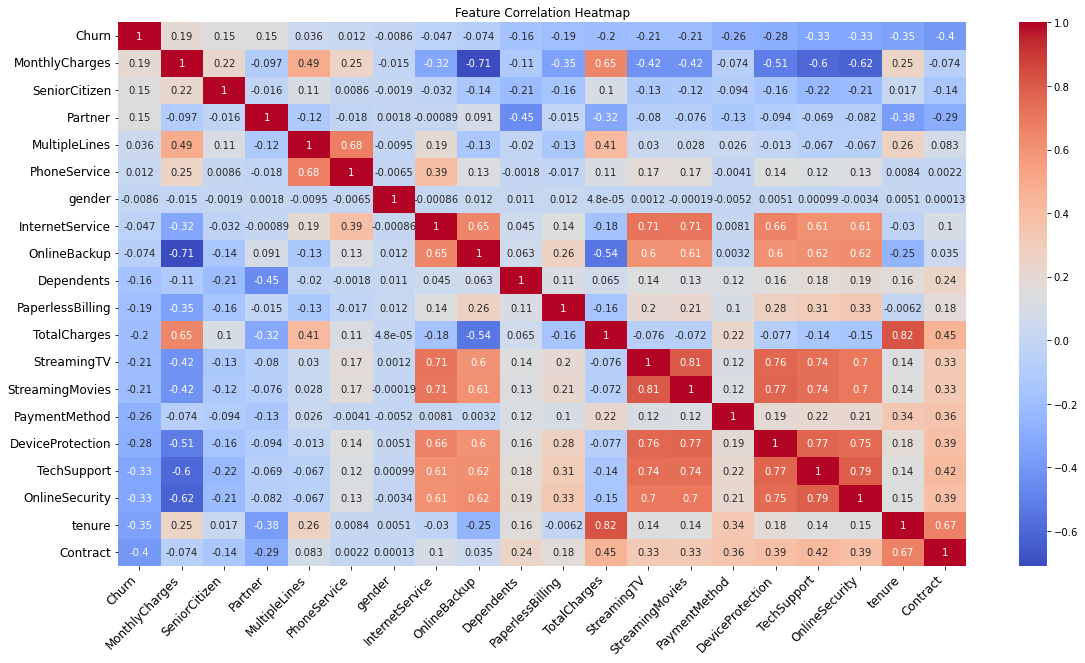

In [14]:
corr = data_labeled.corr()
corr_sorted = corr[target_column].sort_values(ascending=False)
corr_sorted = corr.loc[corr_sorted.index, corr_sorted.index]
fig, ax = plt.subplots(figsize=(19, 10))
sns.heatmap(corr_sorted, annot=True, cmap='coolwarm')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=12, ha='right')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=12)
ax.set_title('Feature Correlation Heatmap')
plt.show()

It seems the 'contract' and 'tenure' features have a moderate negative correlation with Churn, which means as the contract goes up the probability of Churn to be one decreases. On the other hand, the 'MonthlyCharges' has a positive correlation with Churn, which means as the MonthlyCharges goes up, the probability of churn to be zero decreases. The correlation heatmap could be a little overwhelming due to the number of features. So:

<AxesSubplot:>

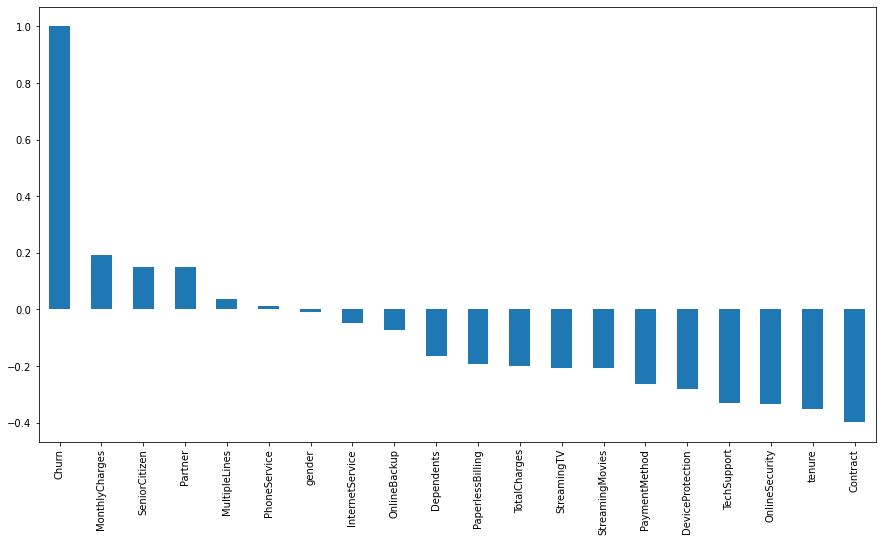

In [15]:
plt.figure(figsize=(15,8))
corr[target_column].sort_values(ascending = False).plot(kind='bar')

Using 'data_dummies' for correlation can help us understand features and the effectiveness of their categories better:

<AxesSubplot:>

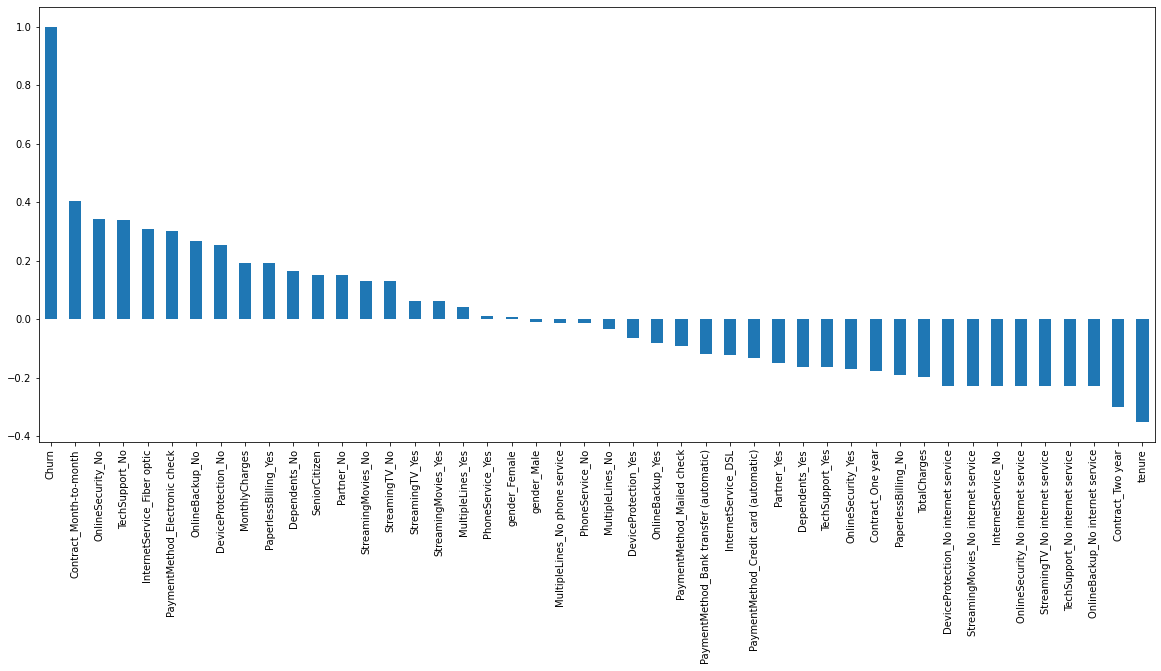

In [16]:
plt.figure(figsize=(20,8))
data_dummies.corr()[target_column].sort_values(ascending = False).plot(kind='bar')

Split data into train and test:

In [17]:
test_prob = 0.2
X = data_dummies.drop(target_column, axis=1)
y = data_dummies[target_column]

train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=test_prob, random_state=util.seed)

Stack modeling, and defining scoring metrics:

In [18]:
models = {'LR': LogisticRegression(random_state=util.seed),
          'KNN': KNeighborsClassifier(),
          'DT': DecisionTreeClassifier(random_state=util.seed),
          'RFC': RandomForestClassifier(random_state=util.seed),
          'XGB': XGBClassifier(random_state=util.seed),
          'LightGBM': LGBMClassifier(random_state=util.seed),
          'CatBoost': CatBoostClassifier(verbose=False, random_state=util.seed)}
n_splits = 10
n_repeats = 3
scoring = ['accuracy', 'recall', 'precision', 'f1']

Run models and doing a solid and robust evaluation:

-- LR ---
fit_time: 0.059
score_time: 0.009
test_accuracy: 0.803
test_f1: 0.594
test_roc_auc: 0.844
test_precision: 0.655
test_recall: 0.544


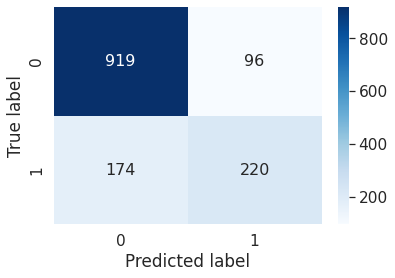

-- KNN ---
fit_time: 0.004
score_time: 0.049
test_accuracy: 0.756
test_f1: 0.527
test_roc_auc: 0.770
test_precision: 0.543
test_recall: 0.512


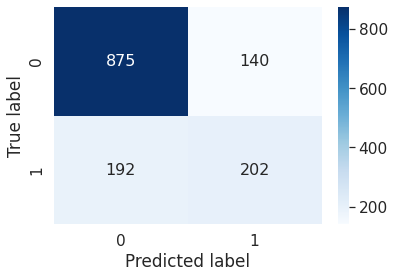

-- DT ---
fit_time: 0.044
score_time: 0.009
test_accuracy: 0.726
test_f1: 0.489
test_roc_auc: 0.653
test_precision: 0.485
test_recall: 0.494


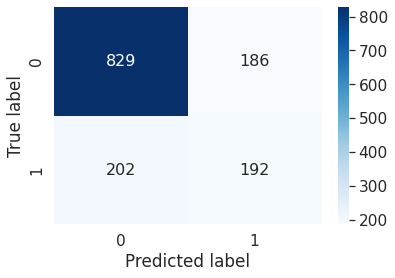

-- RFC ---
fit_time: 0.685
score_time: 0.057
test_accuracy: 0.787
test_f1: 0.543
test_roc_auc: 0.819
test_precision: 0.631
test_recall: 0.478


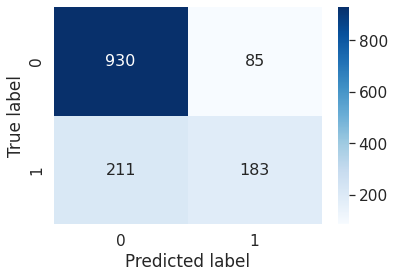

-- XGB ---
fit_time: 0.618
score_time: 0.014
test_accuracy: 0.787
test_f1: 0.561
test_roc_auc: 0.826
test_precision: 0.620
test_recall: 0.513


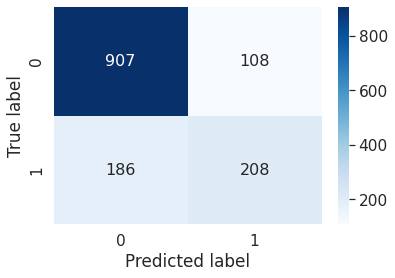

-- LightGBM ---
fit_time: 0.129
score_time: 0.013
test_accuracy: 0.797
test_f1: 0.575
test_roc_auc: 0.837
test_precision: 0.647
test_recall: 0.519


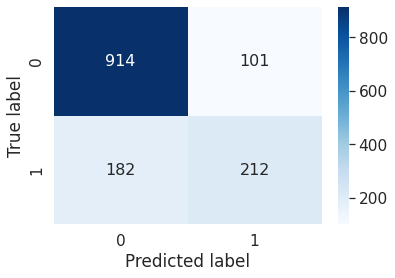

-- CatBoost ---
fit_time: 2.263
score_time: 0.017
test_accuracy: 0.798
test_f1: 0.574
test_roc_auc: 0.842
test_precision: 0.652
test_recall: 0.514


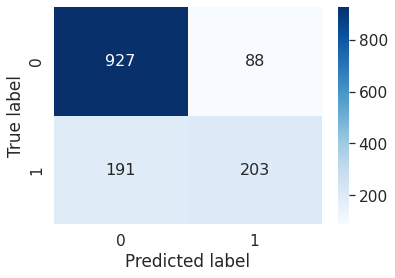

In [19]:
def running_models(X, y, train_x, train_y, test_x, test_y):
    for name in models:
        model = models[name]
        # I learnt it from Imbalanced Classification from machine learning mastery. It stratifies
        # the data.
        cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=util.seed)
        scores = cross_validate(model, X, y, cv=cv, scoring=['accuracy', 'f1', 'roc_auc', 'precision', 'recall'])
        print('--', name, '---')
        for metric in scores:
            metric_scores = scores[metric]
            mean_metric = metric_scores.mean()
            print(f"{metric}: {mean_metric:.3f}")

        model.fit(train_x, train_y)
        c_matrix = confusion_matrix(test_y, model.predict(test_x))
        sns.set(font_scale=1.4)
        sns.heatmap(c_matrix, annot=True, annot_kws={'size': 16}, cmap='Blues', fmt='g')
        plt.xlabel('Predicted label')
        plt.ylabel('True label')
        plt.show()

running_models(X, y, train_x, train_y, test_x, test_y)

There are several methods for oversampling(increasing data points in the minority class) and undersampling(decreasing datapoints in majority class). One of the top oversampling methods is SMOTE. SMOTE draws a line between two datapoints in minority class and then creates new data points in this line. Borderline SMOTE is a variation of SMOTE that balances skewed class by creating data points in critical postition that two classes have overlap. As a result, the models can predict minority class with more confidence.
For undersampling methods, Tomek Links is one of the widely used techniques. Tomek Links identify pairs of examples that are nearest neighbors but belong to different classes, and removes the majority class example from each pair. This can be an effective technique for improving the performance of the classifier on the minority class. However, it can also lead to loss of information from the majority class, and in some cases may not work well with noisy or overlapping data. 
A combination of both oversampling/undersampling methods can be more powerful. Here we use SMOTE for synthesized new data in minority class, and then use Tomek Link to find pairs that are nearest neighbors but in different classes and remove one or both data points:

In [20]:
test_prob = 0.2
X = data_dummies.drop(target_column, axis=1)
y = data_dummies[target_column]
print(y.value_counts())
sampler = SMOTETomek(tomek=TomekLinks(sampling_strategy='majority')) # Try also pure SMOTE(), SVMSMOTE(), and BorderlineSMOTE()
X, y = sampler.fit_resample(X, y)
print(y.value_counts())

train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=test_prob, random_state=util.seed)

0.0    5174
1.0    1869
Name: Churn, dtype: int64
1.0    5174
0.0    4875
Name: Churn, dtype: int64


Run models on the balanced dataset and do a robust performance checking:

--- LR ---
fit_time: 0.08508469263712565
score_time: 0.008329963684082032
test_accuracy: 0.7959528323513194
test_recall: 0.842602718566574
test_precision: 0.7804952027296707
test_f1: 0.8101879859263831


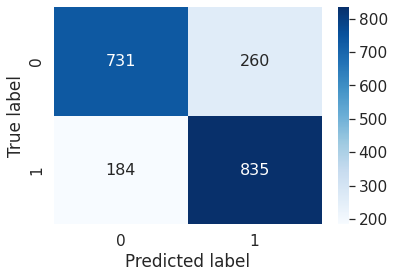

--- KNN ---
fit_time: 0.0063231468200683595
score_time: 0.0679093837738037
test_accuracy: 0.8045369354968618
test_recall: 0.9176959762125423
test_precision: 0.7564472535168197
test_f1: 0.8291938363478103


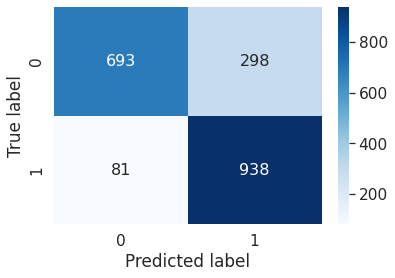

--- DT ---
fit_time: 0.062159339586893715
score_time: 0.006656074523925781
test_accuracy: 0.8051581032157601
test_recall: 0.8126724204510349
test_precision: 0.8111623241781551
test_f1: 0.8116352350026291


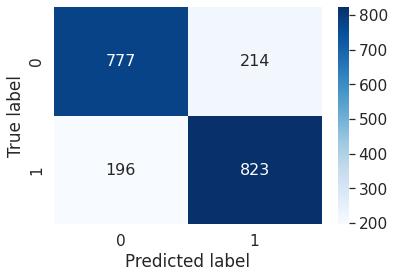

--- RFC ---
fit_time: 0.9239990949630738
score_time: 0.03354116280873617
test_accuracy: 0.873574221049175
test_recall: 0.8851170064874885
test_precision: 0.8725244904643618
test_f1: 0.8786268463671764


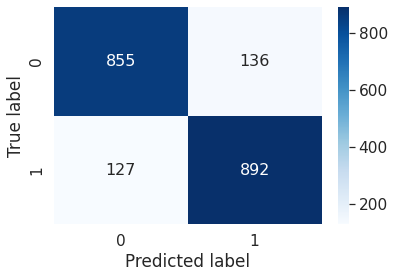

--- XGB ---
fit_time: 1.8299718221028647
score_time: 0.009888553619384765
test_accuracy: 0.8615903979479935
test_recall: 0.868916434970652
test_precision: 0.864301301030608
test_f1: 0.8664585153882243


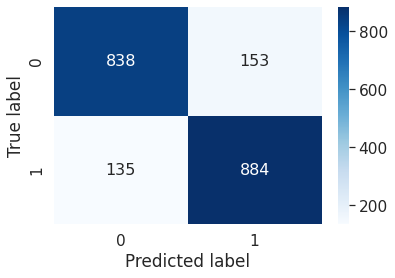

--- LightGBM ---
fit_time: 0.28199850718180336
score_time: 0.014684104919433593
test_accuracy: 0.866027376608035
test_recall: 0.8802255174544331
test_precision: 0.8634468333463404
test_f1: 0.871652681583212


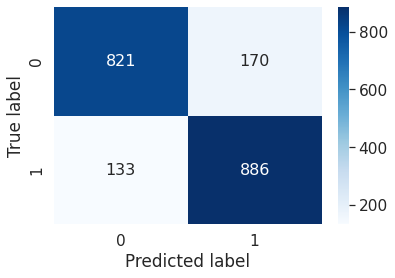

--- CatBoost ---
fit_time: 23.61325985590617
score_time: 0.03106093406677246
test_accuracy: 0.8666497318306764
test_recall: 0.8758126737720112
test_precision: 0.8676804149172707
test_f1: 0.8715947879879212


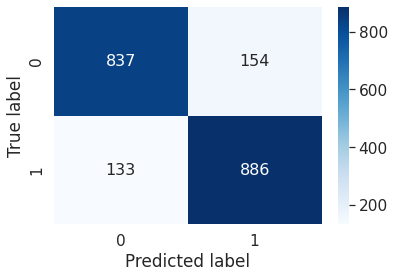

In [21]:

for name in models:
    model = models[name]
    print('---', name, '---')
    model.fit(train_x, train_y)
    cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=util.seed)
    scores = cross_validate(model, train_x, train_y, scoring=scoring, cv=cv, n_jobs=-1)
    for metric in scores:
        metric_scores = scores[metric]
        mean_metric = metric_scores.mean()
        print(f"{metric}: {mean_metric}")
    c_matrix = confusion_matrix(test_y, model.predict(test_x))
    sns.set(font_scale=1.4)
    sns.heatmap(c_matrix, annot=True, annot_kws={'size': 16}, cmap='Blues', fmt='g')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()